In [ ]:
# default_exp data.datasets

In [ ]:
# hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# hide
from nbdev.showdoc import *
from nbdev.export import *
from nbdev.imports import Config as NbdevConfig

data_path = str(NbdevConfig().path("nbs_path")/'data')
data_path

'/Users/ayushman/Desktop/lightning_cv/nbs/data'

In [ ]:
# export
import os
import pandas as pd
from typing import *
from pathlib import Path
import matplotlib.pyplot as plt
from abc import ABC, abstractclassmethod
from fastcore.all import store_attr, ifnone, delegates

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import make_dataset

from lightning_cv.utils.common import default_logger, Registry
from lightning_cv.utils.data import folder2df, IMG_EXTENSIONS, Loaders
from lightning_cv.data.transforms import ImageClassificationTransforms

logger = default_logger()

In [ ]:
# hide
# for tests
from lightning_cv.utils.data import download_data, Urls
from lightning_cv.utils.common import imshow_tensor
from lightning_cv.data.transforms import *

download_data(Urls.DOGS)
data_path = f"{data_path}/cats_and_dogs_filtered/train"

Using downloaded and verified file: /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip
Extracting /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO:Lcv.utils.data:Data downloaded to /Users/ayushman/Desktop/lightning_cv/nbs/data


In [ ]:
# export
class ImageFolderDataset(Dataset):
    "Create `Dataset` instance from `source` using `tfm`"

    def __init__(self, 
                 source: Union[str, Path], 
                 tfm: ImageClassificationTransforms, 
                 classes: Dict = None, 
                 loader: str = "pil_loader", 
                 test : bool = False):
        
        store_attr("source, tfm, test")
        self.loader = Loaders.get(loader)
        
        if not self.test:
            self.classes = ifnone(classes, self._find_classes(self.source))
            samples = make_dataset(self.source, self.classes, IMG_EXTENSIONS, None)
            self.images  = [s[0] for s in samples]
            self.targets = [s[1] for s in samples]
            logger.info(f"Found {len(self.images)} files belonging to {len(set(self.targets))} classes.")
        if self.test:
            samples = self.make_test(source)
            self.images = samples
            logger.info(f"Found {len(self.images)} files.")
    
    def _find_classes(self, dir: str) -> Tuple[List[str], Dict[str, int]]:
        "Finds the class folders in the dataset"
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return class_to_idx
    
    @staticmethod
    def has_file_allowed_extension(filename: str, extensions: Tuple[str, ...]) -> bool:
        """
        Checks if a file is an allowed extension.
        Args:
            filename (string): path to a file
            extensions (tuple of strings): extensions to consider (lowercase)
        Returns:
            bool: True if the filename ends with one of given extensions

        From : https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py
        """
        return filename.lower().endswith(extensions)
    
    @staticmethod
    def is_valid_file(x: str) -> bool:
        return ImageFolderDataset.has_file_allowed_extension(x, cast(Tuple[str, ...], IMG_EXTENSIONS))
    
    @staticmethod
    def make_test(root: str):
        instances = []
        is_valid_file = cast(Callable[[str], bool], ImageFolderDataset.is_valid_file)
        for fname in os.listdir(root):
            path = os.path.join(root, fname)
            if is_valid_file(path):
                instances.append(path)
        return instances
    
    def reload_tfm(self, tfm: ImageClassificationTransforms):
        "reloads the transformations in the `Dataset`"
        self.tfm = tfm
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image  = self.images[index]
        image  = self.loader(image)
        aug_im = self.tfm(image)
        if self.test:
            return aug_im
        else:
            label  = self.targets[index]
            return aug_im, torch.tensor(label, dtype=torch.long)

In [ ]:
show_doc(ImageFolderDataset)

<h2 id="ImageFolderDataset" class="doc_header"><code>class</code> <code>ImageFolderDataset</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>ImageFolderDataset</code>(**\*`args`**, **\*\*`kwds`**) :: `Dataset`

Create `Dataset` instance from `source` using `tfm`

Required arguments :
- **`source`: `Union[str, Path]`** - Source directory of the Images
- **`tfm`: `ImageClassificationTransforms`** - Transformations to apply to the images

You can optinally pass in **`classes`**, which should be a `Dict` that contains a mapping of `{class_name: interger_label}` and **`test`** ; if not `test`, `target`s are not returned, only images are returned after applying `tfm`

Images should arranged in this way:

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

> Note: `loader: str` should be a item in `Loaders` Catalog.

INFO:__main__:Found 2000 files belonging to 2 classes.


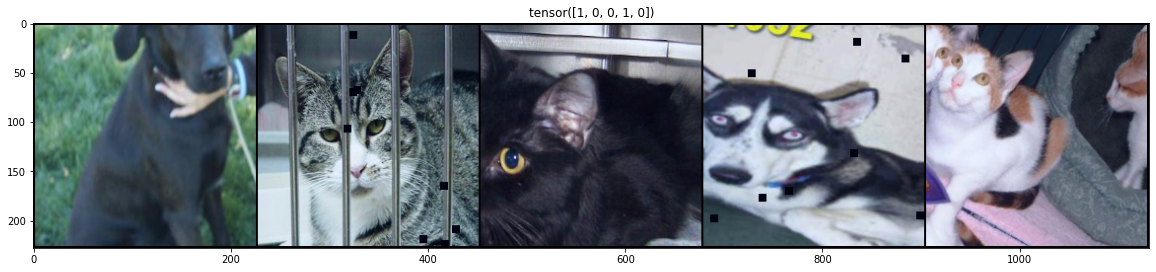

In [ ]:
tfm = AugTransforms(p_cutout=0.5)
ds  = ImageFolderDataset(source=data_path, tfm=tfm, loader="cv2_loader")
dl  = DataLoader(ds, batch_size=5, shuffle=True)
image, target = next(iter(dl))
plt.figure(figsize=(20,10))
imshow_tensor(image, target, normalize=True)

Transformations can also be reloaded after instantiating the `Dataset`.

In [ ]:
show_doc(ImageFolderDataset.reload_tfm)

<h4 id="ImageFolderDataset.reload_tfm" class="doc_header"><code>ImageFolderDataset.reload_tfm</code><a href="__main__.py#L61" class="source_link" style="float:right">[source]</a></h4>

> <code>ImageFolderDataset.reload_tfm</code>(**`tfm`**:[`ImageClassificationTransforms`](/lightning_cv/data.transforms.html#ImageClassificationTransforms))

reloads the transformations in the `Dataset`

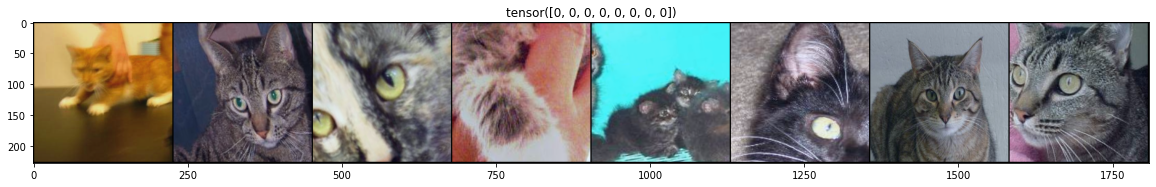

In [ ]:
tfm = AugTransforms(p_cutout=0.0)
ds.reload_tfm(tfm)

dl  = DataLoader(ds, batch_size=8)
image, target = next(iter(dl))
plt.figure(figsize=(20,10))
imshow_tensor(image, target, normalize=True)

Generating a Test Dataset (Dataset without test labels) : 

In [ ]:
# hide
os.listdir(data_path)

['dogs', 'cats', 'train.csv']

INFO:__main__:Found 1000 files.


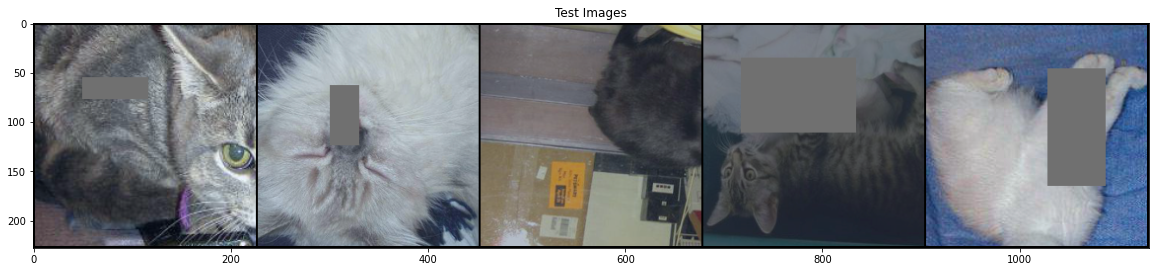

In [ ]:
tfm = GenericImageTransform(re_prob=0.5)
ds  = ImageFolderDataset(
    source=os.path.join(data_path, "cats"), 
    tfm=tfm, loader="pil_loader", 
    test=True)

dl  = DataLoader(ds, batch_size=5, shuffle=True)
image = next(iter(dl))
plt.figure(figsize=(20,10))
imshow_tensor(image, title="Test Images", normalize=True)

In [ ]:
#hide
pd.set_option('display.max_colwidth', None)
df = folder2df(data_path, extension=IMG_EXTENSIONS, shuffle=True)

def _map_fn(name): return 0 if name == "cats" else 1

df["label"] = df["target"].map(_map_fn)
df.to_csv(f"{data_path}/train.csv", index=False)

df.head()

INFO:Lcv.utils.data:Found 2000 files belonging to 2 classes.


,image_id,target,label
0,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.867.jpg,cats,0
1,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.718.jpg,cats,0
2,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.746.jpg,dogs,1
3,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.203.jpg,cats,0
4,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.120.jpg,dogs,1


In [ ]:
#hide
os.listdir(data_path)

['dogs', 'cats', 'train.csv']

In [ ]:
# export
class ImageCsvDataset(Dataset):
    "Create `Dataset` instance from `csv` using `tfm`, `image_col` and `label_col`"

    @delegates(pd.read_csv)
    def __init__(self,
                 csv: str,
                 image_col: str,
                 tfm: ImageClassificationTransforms,
                 label_col: Optional[str] = None,
                 loader: str = "pil_loader",
                 test: bool = False,
                 **kwargs):

        store_attr("label_col, image_col, tfm, test")
        self.df = pd.read_csv(csv, **kwargs)
        self.loader = Loaders.get(loader)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image  = self.df[self.image_col][index]
        image  = self.loader(image)
        aug_im = self.tfm(image)

        if self.test:
            return aug_im
        if not self.test:
            label = self.df[self.label_col][index]
            label = torch.tensor(label, dtype=torch.long)
            return aug_im, label

In [ ]:
show_doc(ImageCsvDataset)

<h2 id="ImageCsvDataset" class="doc_header"><code>class</code> <code>ImageCsvDataset</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>ImageCsvDataset</code>(**\*`args`**, **\*\*`kwds`**) :: `Dataset`

Create `Dataset` instance from `csv` using `tfm`, `image_col` and `label_col`

Arguments:
- **`csv (str)`**: path to the csv file.
- **`image_col (str)`**: name of the column where the image paths are stored.
- **`tfm (ImageClassificationTransforms)`**: transformations to apply to the images.
- **`label_col (Optional[str])`**: name of the column where the labels for the images are stored.
- **`loader (str)`**: item in `Loaders` registery for reading the Images.
- **`test (bool)`**: if test , then only images are returned and `label_col` is skipped.
- **`kwargs`** : arguemnts for `pd.read_csv`

Example - 

In [ ]:
#hide input
df.head()

,image_id,target,label
0,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.867.jpg,cats,0
1,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.718.jpg,cats,0
2,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.746.jpg,dogs,1
3,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.203.jpg,cats,0
4,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.120.jpg,dogs,1


Let's create `Dataset` s and `DataLoader`s from the above csv file.

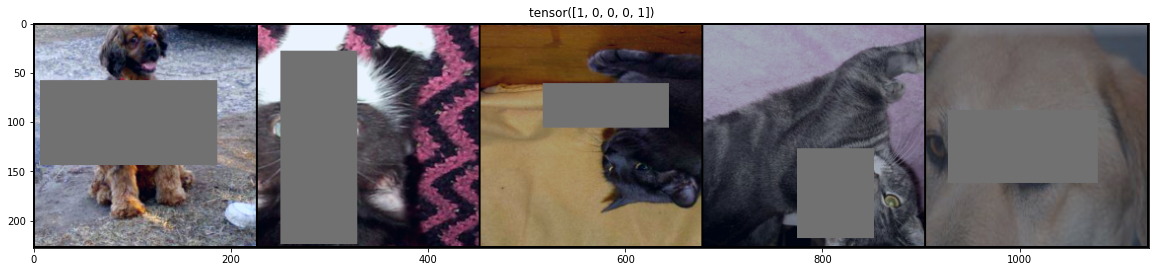

In [ ]:
csv  = f"{data_path}/train.csv"
tfm  = GenericImageTransform(img_size=224, re_prob=1.0)

ds = ImageCsvDataset(csv, image_col="image_id", 
                     label_col="label", tfm=tfm, 
                     test=False, loader="pil_loader")

dl  = DataLoader(ds, batch_size=5, shuffle=True)
image, target = next(iter(dl))
plt.figure(figsize=(20,10))
imshow_tensor(image, target, normalize=True)

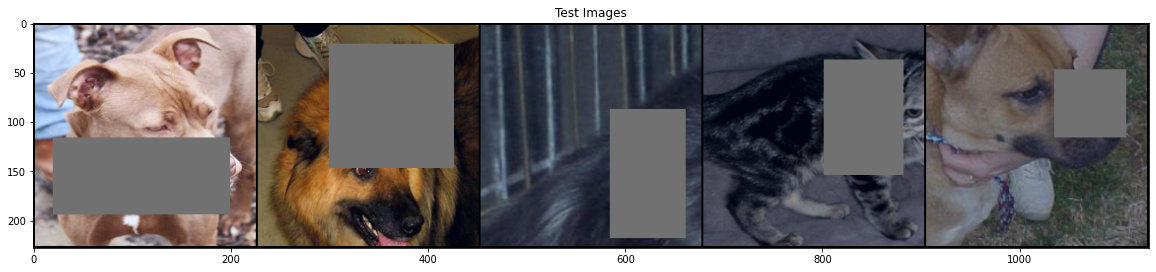

In [ ]:
csv  = f"{data_path}/train.csv"
tfm  = GenericImageTransform(img_size=224, re_prob=1.0)

ds = ImageCsvDataset(csv, image_col="image_id", 
                     label_col=None, tfm=tfm, 
                     test=True, loader="pil_loader")

dl  = DataLoader(ds, batch_size=5, shuffle=True)


image = next(iter(dl))
plt.figure(figsize=(20,10))
imshow_tensor(image, "Test Images", normalize=True)

In [ ]:
# hide
notebook2script()

Converted 00a_utils.common.ipynb.
Converted 00b_utils.data.ipynb.
Converted 01a_data.transforms.ipynb.
Converted 01b_data.datasets.ipynb.
Converted index.ipynb.
